<a href="https://colab.research.google.com/github/naxda/Just-Try-2019/blob/master/COVID_19_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **데이터 다운로드**

In [0]:
# # COVID-19 데이터셋 다운로드 (from Joseph Paul Cohen PhD)
# !git clone https://github.com/ieee8023/covid-chestxray-dataset.git

In [0]:
# # 정상 데이터셋 다운로드 (from Kaggle)

# # 캐글 등록
# !pip install kaggle
# from google.colab import files
# files.upload()

In [0]:
# !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json

기존 [PyImageSearch](https://www.pyimagesearch.com/2020/03/16/detecting-covid-19-in-x-ray-images-with-keras-tensorflow-and-deep-learning/?fbclid=IwAR1C8t36KTCpNxSbXpBtIHv1Q6jjmJuJ7cFRYSPaaSXnRO9cWYDTcuOTXZs) 에서 사용하였던 [Chest X-ray](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia) 데이터셋은 영유아의 샘플만 존재하여, [NIH Chest X-ray](https://www.kaggle.com/nih-chest-xrays/sample)를 사용하였습니다.

In [0]:
# !kaggle datasets download -d nih-chest-xrays/sample
# !unzip sample.zip

## **데이터 전처리**

In [0]:
from pathlib import Path
import cv2
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [0]:
def get_fold_df(df, num_folds):
    num_samples = len(df)
    skf = StratifiedKFold(n_splits=num_folds, random_state=2020, shuffle=True)
    
    fold_info = np.zeros((num_samples), dtype='uint8')
    for idx, (train_index, test_index) in enumerate(skf.split(df['ImageID'], df['target'])):
        fold_info[test_index] = idx

    df['fold'] = fold_info
    return df

In [0]:
normal_dir = Path('./sample/sample/images/')
normal_csv_path = Path('./sample/sample_labels.csv')
covid_dir = Path('./covid-chestxray-dataset/images/')
covid_csv_path = Path('./covid-chestxray-dataset/metadata.csv')

normal_df = pd.read_csv(normal_csv_path)
normal_df = normal_df[normal_df['Finding Labels'] == 'No Finding'][normal_df['View Position'] == 'PA'].reset_index(drop=True)
covid_df = pd.read_csv(covid_csv_path)
covid_df = covid_df[covid_df['finding'] == 'COVID-19'][covid_df['view'] == 'PA'].reset_index(drop=True)

num_folds = 5

Data Imbalance를 완화하기 위해 COVID-19 양성의 수와 같게 음성 데이터를 샘플링하였습니다.

In [0]:
covid_ids = covid_df.filename.values
num_covid = len(covid_ids)

normal_ids = normal_df['Image Index'].values[:num_covid]
num_normal = len(normal_ids)

In [0]:
ids = np.concatenate([covid_ids,  normal_ids])
targets = [1] * num_covid + [0] * num_normal

df = pd.DataFrame({'ImageID': ids, 'target': targets})
df = get_fold_df(df, 5)

In [0]:
df

,ImageID,target,fold
0,auntminnie-a-2020_01_28_23_51_6665_2020_01_28_...,1,3
1,auntminnie-b-2020_01_28_23_51_6665_2020_01_28_...,1,3
2,auntminnie-c-2020_01_28_23_51_6665_2020_01_28_...,1,2
3,auntminnie-d-2020_01_28_23_51_6665_2020_01_28_...,1,4
4,nejmc2001573_f1a.jpeg,1,2
...,...,...,...
107,00000779_001.png,0,1
108,00000781_006.png,0,3
109,00000805_001.png,0,0
110,00000809_001.png,0,1


### COVID-19 양성 데이터

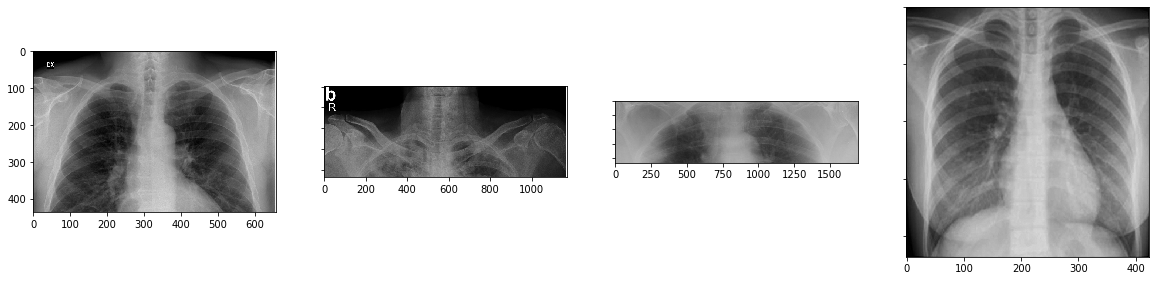

In [0]:
num_samples = 4
samples_idx = np.random.choice(df[df['target']==1].index.values, size=num_samples)

fig, ax = plt.subplots(nrows=1, ncols=num_samples, sharey=True, figsize=(num_samples*5,10))
for i, sample_id in enumerate(samples_idx):
    image_id = df.iloc[sample_id].ImageID
    image = cv2.imread(str(covid_dir / image_id))
    ax[i].imshow(image, cmap=plt.cm.bone)

### COVID-19 음성 데이터

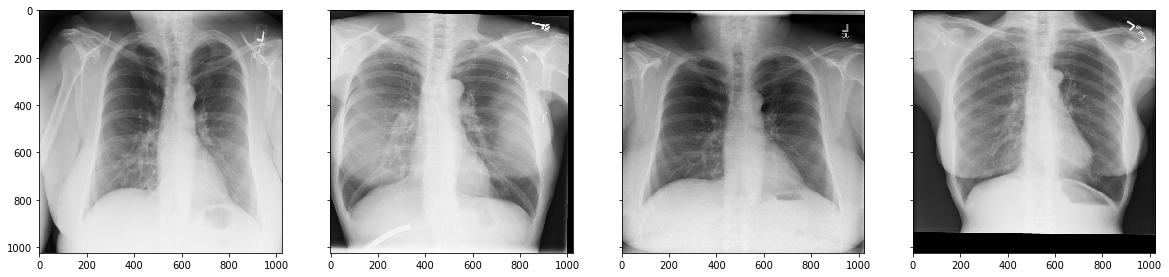

In [0]:
num_samples = 4
samples_idx = np.random.choice(df[df['target']==0].index.values, size=num_samples)

fig, ax = plt.subplots(nrows=1, ncols=num_samples, sharey=True, figsize=(num_samples*5,10))
for i, sample_id in enumerate(samples_idx):
    image_id = df.iloc[sample_id].ImageID
    image = cv2.imread(str(normal_dir / image_id))
    ax[i].imshow(image, cmap=plt.cm.bone)

## **Pytorch를 이용한 COVID-19 양성 분류기**

In [0]:
import torch
from torch.utils.data import Dataset, DataLoader

from albumentations.pytorch import ToTensor
from albumentations.core.composition import Compose, OneOf
from albumentations.augmentations.transforms import Normalize, HorizontalFlip, ShiftScaleRotate, Resize, \
    RandomContrast, RandomGamma, RandomBrightness, ElasticTransform, GridDistortion, OpticalDistortion, \
    RandomCrop

class covidDataset(Dataset):
    def __init__(self, normal_dir, covid_dir, df, fold, phase):
        self.normal_dir = normal_dir
        self.covid_dir = covid_dir
        if phase == 'train':
            self.df = df[df['fold']!=fold].reset_index(drop=True)[['ImageID','target']]
            self.transforms = Compose([HorizontalFlip(),
                                       OneOf([RandomContrast(), RandomGamma(), RandomBrightness()], p=0.3),
                                       OneOf([ElasticTransform(alpha=120,sigma=6,alpha_affine=3.6,),
                                              GridDistortion(),
                                              OpticalDistortion()], p=0.3),
                                       ShiftScaleRotate(),
                                       Resize(512, 512),
                                       RandomCrop(448, 448),
                                       Normalize(),
                                       ToTensor()])
        else:
            self.df = df[df['fold']==fold].reset_index(drop=True)[['ImageID','target']]
            self.transforms = Compose([Resize(512, 512),
                                       Normalize(),
                                       ToTensor()])
        self.length = len(self.df)

    def __getitem__(self, idx):
        ImageID, target = self.df.iloc[idx]
        if target == 0:
            image = cv2.imread(str(self.normal_dir / ImageID))
        else:
            image = cv2.imread(str(self.covid_dir / ImageID))
        image = self.transforms(image=image)['image']
        return image, target

    def __len__(self):
        return self.length

In [0]:
from sklearn.metrics import accuracy_score

class Evaluator(object):
    def __init__(self):
        self.Acc = 0
        self.num_batch = 0

    def add_batch(self, targets, predictions):
        batch_acc = accuracy_score(targets, predictions)
        self.Acc = (self.Acc * self.num_batch + batch_acc) / (self.num_batch + 1)
        self.num_batch += 1

    def reset(self):
        self.Acc = 0
        self.num_batch = 0

In [0]:
from tqdm import tqdm_notebook

class Learning():
    def __init__(self,
                 optimizer,
                 loss_fn,
                 evaluator,
                 device,
                 n_epoches,
                 scheduler,
                 accumulation_step,
                 save_dir='./model'):
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        self.evaluator = evaluator
        self.device = device
        self.n_epoches = n_epoches
        self.scheduler = scheduler
        self.accumulation_step = accumulation_step
        self.best_checkpoint_path = Path(
            save_dir,
            'best_model.pth'
        )
        self.best_score = 0
        self.best_epoch = -1
        self.summary = {'train_loss': [], 'val_loss': [], 'val_acc': []}
        
    def train_epoch(self, model, loader):
        tqdm_loader = loader
        # tqdm_loader = tqdm_notebook(loader)
        current_loss_mean = 0.
        for idx, (batch_imgs, batch_labels) in enumerate(tqdm_loader):
            if (idx + 1) % self.accumulation_step == 0:
                self.optimizer.zero_grad()

            loss = self.batch_train(model, batch_imgs, batch_labels)
            current_loss_mean = (current_loss_mean * idx + loss.item()) / (idx + 1)

            if (idx + 1) % self.accumulation_step == 0:
                self.optimizer.step()

            # tqdm_loader.set_description(f'loss: {current_loss_mean:.4f} lr: {self.optimizer.param_groups[0]["lr"]:.6f}')
        return current_loss_mean

    def batch_train(self, model, batch_images, batch_labels):
        batch_images = batch_images.to(device=self.device)
        batch_labels = batch_labels.to(device=self.device).long()

        batch_preds = model(batch_images)
        loss = self.loss_fn(batch_preds, batch_labels) / self.accumulation_step

        loss.backward()

        return loss

    def valid_epoch(self, model, loader):
        tqdm_loader = loader
        # tqdm_loader = tqdm_notebook(loader)
        current_loss_mean = torch.tensor(0.).cuda()
        for idx, (batch_imgs, batch_labels) in enumerate(tqdm_loader):
            with torch.no_grad():
                batch_labels = batch_labels.to(device=self.device).long()
                batch_pred = self.batch_valid(model, batch_imgs)
                loss = self.loss_fn(batch_pred, batch_labels)
                current_loss_mean = (current_loss_mean * idx + loss.item()) / (idx + 1)

                batch_pred = batch_pred.data.cpu().numpy()
                batch_labels = batch_labels.cpu().numpy()
                batch_pred = np.argmax(batch_pred, axis=1)
                self.evaluator.add_batch(batch_labels, batch_pred)

                # tqdm_loader.set_description(f'loss: {current_loss_mean:.5f}')

        return current_loss_mean.item()

    def batch_valid(self, model, batch_imgs):
        batch_imgs = batch_imgs.to(device=self.device)
        batch_pred = model(batch_imgs)
        return batch_pred

    @staticmethod
    def get_state_dict(model):
        if type(model) == torch.nn.DataParallel:
            state_dict = model.module.state_dict()
        else:
            state_dict = model.state_dict()
        return state_dict

    def post_processing(self, score, model):
        if score > self.best_score:
            self.best_score = score
            self.best_epoch = self.epoch
            torch.save(self.get_state_dict(model), self.best_checkpoint_path)
            print('best model: {} epoch - {:.5}'.format(self.epoch, score))
                
        if self.scheduler.__class__.__name__ == 'ReduceLROnPlateau':
            self.scheduler.step(score)
        else:
            self.scheduler.step()

    def run_train(self, model, train_dataloader, valid_dataloader):
        model.to(self.device)
        for self.epoch in range(self.n_epoches):
            self.evaluator.reset()
            
            # print(f'Epoch {self.epoch}: \t start training....')
            model.train()
            train_loss_mean = self.train_epoch(model, train_dataloader)
            # print(f'Epoch {self.epoch}: \t Calculated train loss: {train_loss_mean:.4f}')
            
            # print(f'Epoch {self.epoch}: \t start validation....')
            model.eval()
            valid_loss = self.valid_epoch(model, valid_dataloader)

            self.post_processing(self.evaluator.Acc, model)
            
            print(f'Epoch {self.epoch}: \t train_loss: {train_loss_mean:.4f}, valid_loss: {valid_loss:.4f}, Acc: {self.evaluator.Acc:.4f}')
            self.summary['train_loss'].append(train_loss_mean)
            self.summary['val_loss'].append(valid_loss)
            self.summary['val_acc'].append(self.evaluator.Acc)

        return self.best_epoch, self.best_score, self.summary

In [0]:
import torch.nn as nn
import torchvision

n_epochs = 100
batch_size = 12
num_workers = 4
accumulation_step = 1

train_dataset = covidDataset(normal_dir, covid_dir, df, 0, 'train')
valid_dataset = covidDataset(normal_dir, covid_dir, df, 0, 'valid')

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, num_workers=num_workers,
                          shuffle=True, pin_memory=True)
valid_loader = DataLoader(dataset=valid_dataset, batch_size=1, num_workers=num_workers,
                          shuffle=False, pin_memory=True)

evaluator = Evaluator()

model = torchvision.models.resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=2, T_mult=1, eta_min=1e-6)
device = 'cuda'

save_dir = Path('./model')
if not save_dir.exists():
    save_dir.mkdir()

Learner = Learning(optimizer, loss_fn, evaluator, device, n_epochs, scheduler, accumulation_step, save_dir)
best_epoch, best_score, summary = Learner.run_train(model, train_loader, valid_loader)
print(f'Best Epoch: {best_epoch}, Best Score: {best_score}')

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth



best model: 0 epoch - 0.52174
Epoch 0: 	 train_loss: 0.8404, valid_loss: 147.9188, Acc: 0.5217
best model: 1 epoch - 0.78261
Epoch 1: 	 train_loss: 0.4620, valid_loss: 1.0297, Acc: 0.7826
Epoch 2: 	 train_loss: 0.4274, valid_loss: 1.4690, Acc: 0.6522
Epoch 3: 	 train_loss: 0.4635, valid_loss: 7.4280, Acc: 0.3478
Epoch 4: 	 train_loss: 0.4652, valid_loss: 60.5044, Acc: 0.4348
best model: 5 epoch - 0.86957
Epoch 5: 	 train_loss: 0.4371, valid_loss: 0.2944, Acc: 0.8696
Epoch 6: 	 train_loss: 0.3468, valid_loss: 0.6005, Acc: 0.7391
Epoch 7: 	 train_loss: 0.2810, valid_loss: 0.8529, Acc: 0.6522
Epoch 8: 	 train_loss: 0.3317, valid_loss: 10.1111, Acc: 0.5217
Epoch 9: 	 train_loss: 0.2680, valid_loss: 6.1518, Acc: 0.5652
best model: 10 epoch - 0.95652
Epoch 10: 	 train_loss: 0.3435, valid_loss: 0.2237, Acc: 0.9565
Epoch 11: 	 train_loss: 0.3764, valid_loss: 0.3515, Acc: 0.7826
Epoch 12: 	 train_loss: 0.5458, valid_loss: 9.9209, Acc: 0.4783
Epoch 13: 	 train_loss: 0.2482, valid_loss: 5.5442, 

## **왜 양성이라고 판단하였는가?**
### Grad-CAM을 통한 시각화

In [0]:
model = torchvision.models.resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)

state_dict = torch.load('./model/best_model.pth', map_location=lambda storage, loc: storage)
model.load_state_dict(state_dict)
del model.fc

In [0]:
# Code from https://github.com/jacobgil/pytorch-grad-cam
from torch.autograd import Function

resnet = torchvision.models.resnet50(pretrained=True)

class FeatureExtractor():
    """ Class for extracting activations and 
    registering gradients from targetted intermediate layers """
    def __init__(self, model, target_layers):
        self.model = model
        self.target_layers = target_layers
        self.gradients = []

    def save_gradient(self, grad):
    	self.gradients.append(grad)

    def __call__(self, x):
        outputs = []
        self.gradients = []
        for name, module in self.model._modules.items():
            x = module(x)
            if name in self.target_layers:
                x.register_hook(self.save_gradient)
                outputs += [x]
        return outputs, x


class ModelOutputs():
	""" Class for making a forward pass, and getting:
	1. The network output.
	2. Activations from intermeddiate targetted layers.
	3. Gradients from intermeddiate targetted layers. """
	def __init__(self, model, target_layers,use_cuda):
		self.model = model
		self.feature_extractor = FeatureExtractor(self.model, target_layers)
		self.cuda = use_cuda
	def get_gradients(self):
		return self.feature_extractor.gradients

	def __call__(self, x):
		target_activations, output  = self.feature_extractor(x)
		output = output.view(output.size(0), -1)
		#print('classfier=',output.size())
		if self.cuda:
			output = output.cpu()
			output = resnet.fc(output).cuda()
		else:
			output = resnet.fc(output)
		return target_activations, output


def show_cam_on_image(img, mask):
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    return np.uint8(255 * cam)


def preprocess_image(img):
    means = [0.485, 0.456, 0.406]
    stds = [0.229, 0.224, 0.225]

    preprocessed_img = img.copy()[:, :, ::-1]
    for i in range(3):
        preprocessed_img[:, :, i] = preprocessed_img[:, :, i] - means[i]
        preprocessed_img[:, :, i] = preprocessed_img[:, :, i] / stds[i]
    preprocessed_img = \
        np.ascontiguousarray(np.transpose(preprocessed_img, (2, 0, 1)))
    preprocessed_img = torch.from_numpy(preprocessed_img)
    preprocessed_img.unsqueeze_(0)
    input = preprocessed_img.requires_grad_(True)
    return input


class GradCam:
	def __init__(self, model, target_layer_names, use_cuda):
		self.model = model
		self.model.eval()
		self.cuda = use_cuda
		if self.cuda:
			self.model = model.cuda()

		self.extractor = ModelOutputs(self.model, target_layer_names, use_cuda)

	def forward(self, input):
		return self.model(input) 

	def __call__(self, input, index = None):
		if self.cuda:
			features, output = self.extractor(input.cuda())
		else:
			features, output = self.extractor(input)

		if index == None:
			index = np.argmax(output.cpu().data.numpy())

		one_hot = np.zeros((1, output.size()[-1]), dtype = np.float32)
		one_hot[0][index] = 1
		one_hot = torch.Tensor(torch.from_numpy(one_hot))
		one_hot.requires_grad = True
		if self.cuda:
			one_hot = torch.sum(one_hot.cuda() * output)
		else:
			one_hot = torch.sum(one_hot * output)

		self.model.zero_grad()
		one_hot.backward(retain_graph=True)
        
		grads_val = self.extractor.get_gradients()[-1].cpu().data.numpy()
		target = features[-1]
		target = target.cpu().data.numpy()[0, :]

		weights = np.mean(grads_val, axis = (2, 3))[0, :]
		cam = np.zeros(target.shape[1 : ], dtype = np.float32)
		for i, w in enumerate(weights):
			cam += w * target[i, :, :]

		cam = np.maximum(cam, 0)
		cam = cv2.resize(cam, (512, 512))
		cam = cam - np.min(cam)
		cam = cam / np.max(cam)
		return cam

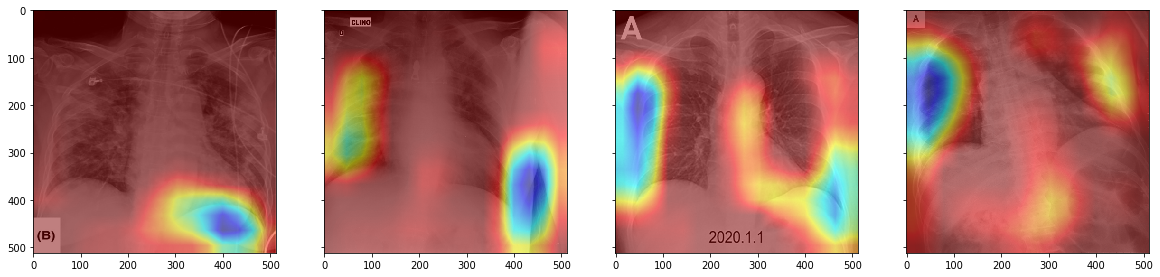

In [0]:
num_samples = 4
samples_idx = np.random.choice(df[df['target']==1].index.values, size=num_samples)
grad_cam = GradCam(model=model, target_layer_names=["layer4"], use_cuda=True)

fig, ax = plt.subplots(nrows=1, ncols=num_samples, sharey=True, figsize=(num_samples*5,10))
for i, sample_id in enumerate(samples_idx):
    image_id = df.iloc[sample_id].ImageID
    image = cv2.imread(str(covid_dir / image_id))
    image = np.float32(cv2.resize(image, (512, 512))) / 255
    input = preprocess_image(image)
    input.required_grad = True
    
    target_index = None
    mask = grad_cam(input, target_index)

    ax[i].imshow(show_cam_on_image(image, mask))

### Reference

*   [COVID-19 Dataset](https://github.com/ieee8023/covid-chestxray-dataset)
*   [NIH Chest X-ray Dataset](https://www.kaggle.com/nih-chest-xrays/sample)
*   [TF2.0을 통한 COVID-19 분류](https://www.pyimagesearch.com/2020/03/16/detecting-covid-19-in-x-ray-images-with-keras-tensorflow-and-deep-learning/?fbclid=IwAR1C8t36KTCpNxSbXpBtIHv1Q6jjmJuJ7cFRYSPaaSXnRO9cWYDTcuOTXZs)
*   [Pytorch Grad-CAM](https://github.com/jacobgil/pytorch-grad-cam) 

오류 및 개선사항: hslee1@unist.ac.kr